In [ ]:
# Dataset Link: https://www.kaggle.com/datasets/taejoongyoon/mitbit-arrhythmia-database/data

In [ ]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense, Dropout, Softmax,MaxPool1D
from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras import regularizers


%matplotlib inline

# matplotlib Settings

In [48]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

# Method Definitions

In [49]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len) # finds max level
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i])) # replaces signals below threshold as 0
        
    datarec = pywt.waverec(coeffs, 'sym4') # reconstructs wave
    
    return datarec


# Variables Definitions

In [50]:
path = '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/'
window_size = 1000
maximum_counting = 10000

classes = ['N', 'SVEB', 'VEB', 'F', 'Q']
n_classes = len(classes)
count_classes = [0] * n_classes

X = list() # ecg segments
y = list() # annotation for each segment

# Preparing Input Files

In [51]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [52]:
# segregating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)
print(records[0])
print(annotations[0])

/kaggle/input/mitbit-arrhythmia-database/mitbih_database/100.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/100annotations.txt


# Extraction of Data and Preprocessing

In [ ]:
def map_annotation(annotation_symbol):
    annotation_map = {
        'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',  # Normal
        'A': 'SVEB', 'a': 'SVEB', 'J': 'SVEB', 'S': 'SVEB', # SVEB
        'V': 'VEB', 'E': 'VEB',                          # VEB
        'F': 'F',                                  # Fusion
        'p': 'Q', '/': 'Q', 'f': 'Q', 'Q': 'Q'           # Unknown
    }
    return annotation_map.get(annotation_symbol, 'U')  # Default to U if not in map


In [ ]:
# Records
for r in range(0, len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    
    # Plot an example to the signals
    signals = denoise(signals)
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            arrhythmia_type = map_annotation(arrhythmia_type)
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


(9061, 2000) (9061,)


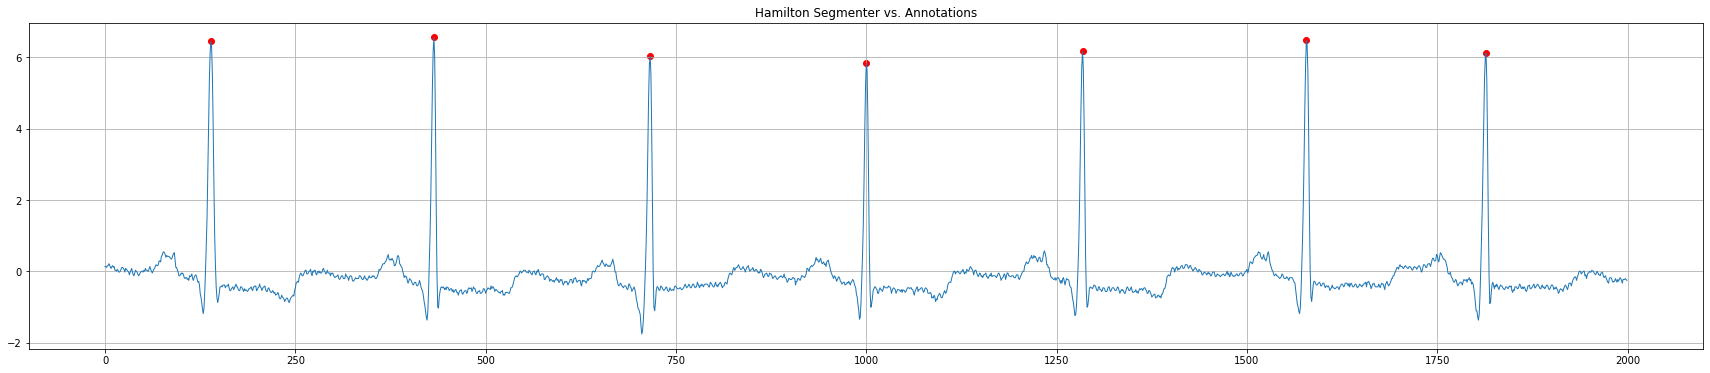

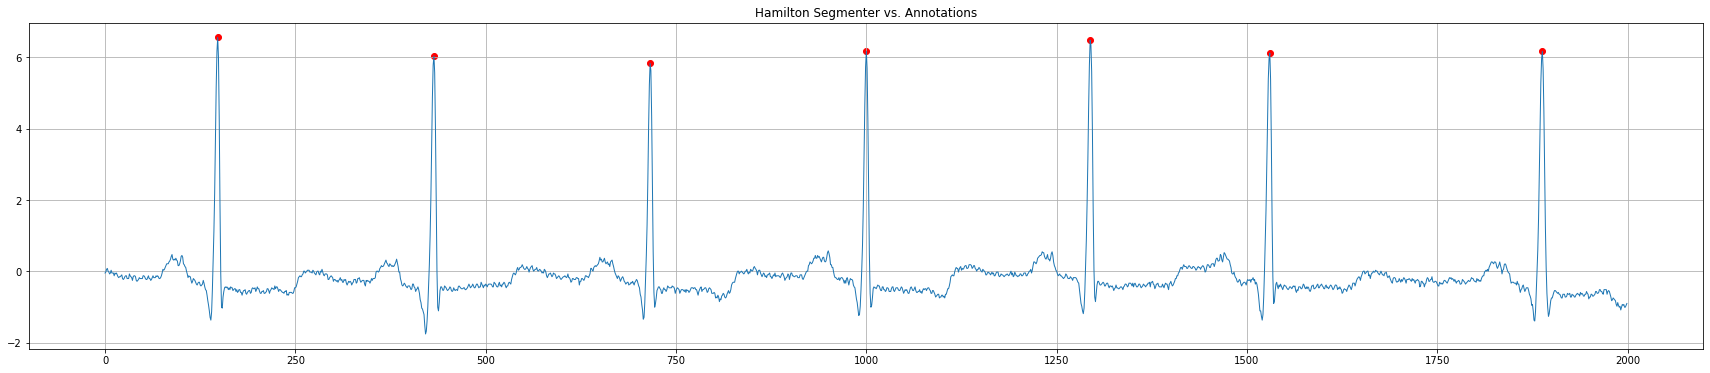

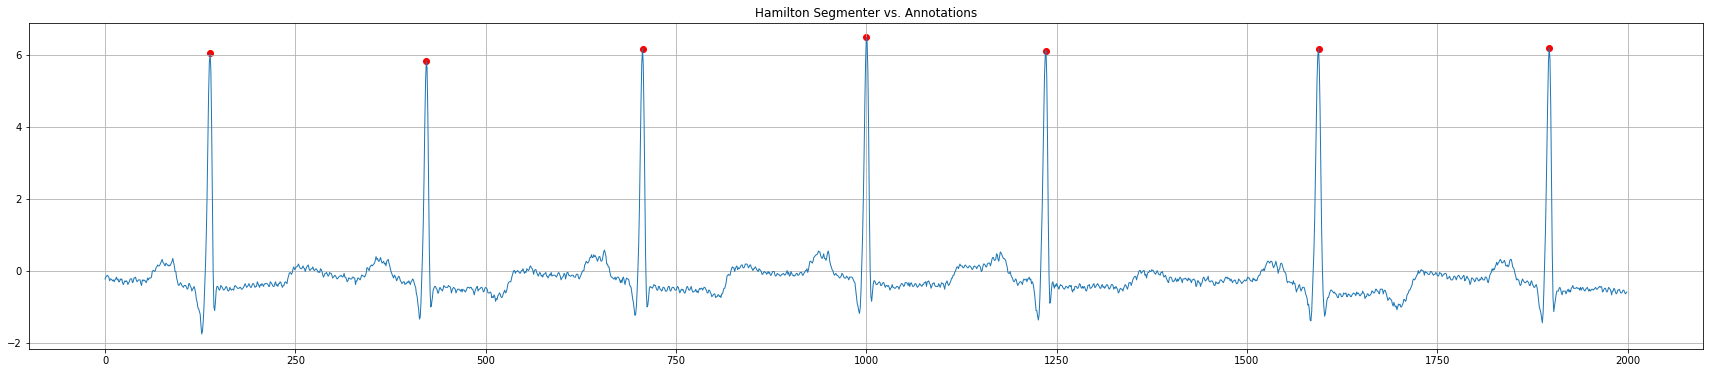

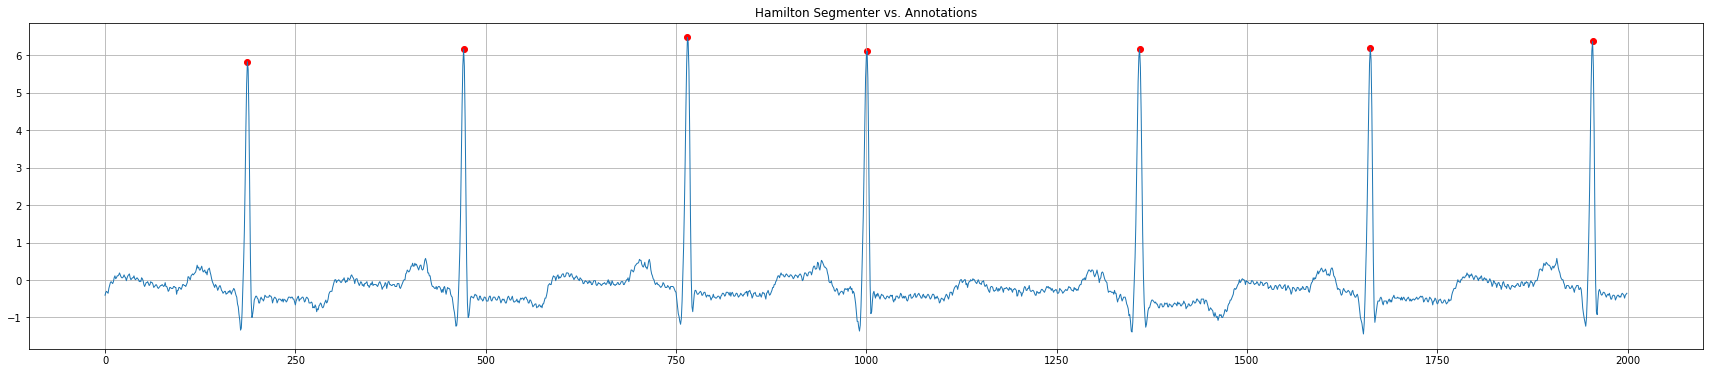

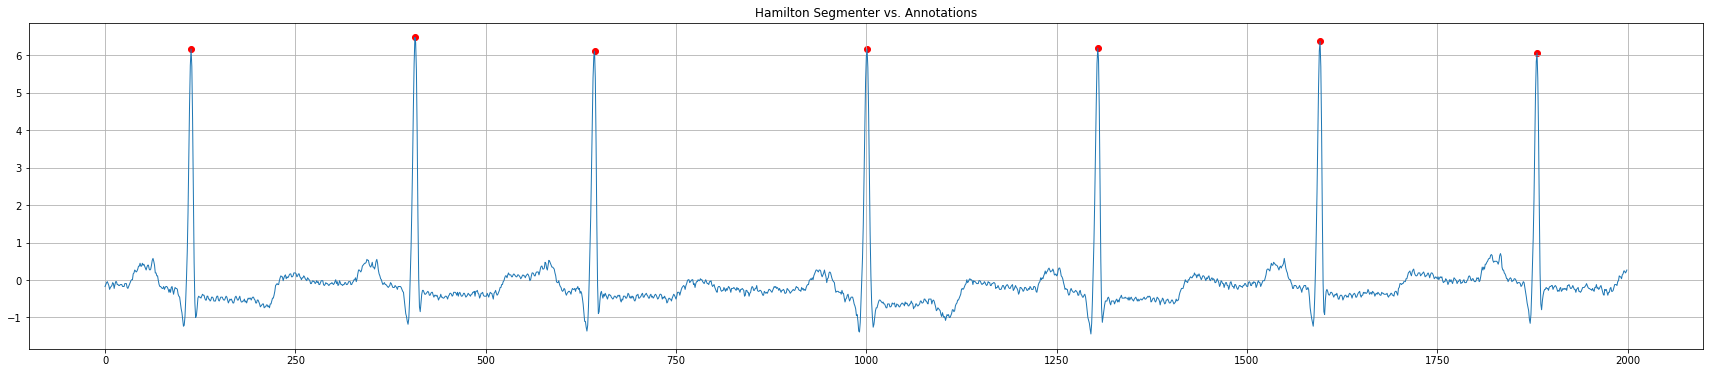

In [87]:
import biosppy

for i in range(5):
    rp = biosppy.signals.ecg.hamilton_segmenter(signal=X[i], sampling_rate=360)
    plt.plot(X[i])
    plt.scatter(rp, X[i][rp], color='red')
    plt.title("Hamilton Segmenter vs. Annotations")
    plt.show()

In [9]:
print(count_classes)

[90631, 2781, 7236, 803, 8043]


In [10]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i]) # Combining signals with annotations

print(np.shape(X))


(109156, 2001)


In [11]:
print(X[1][360])

0.0067234989726539605


# EDA

0.0    90348
4.0     8015
2.0     7220
1.0     2772
3.0      801
Name: 2000, dtype: int64


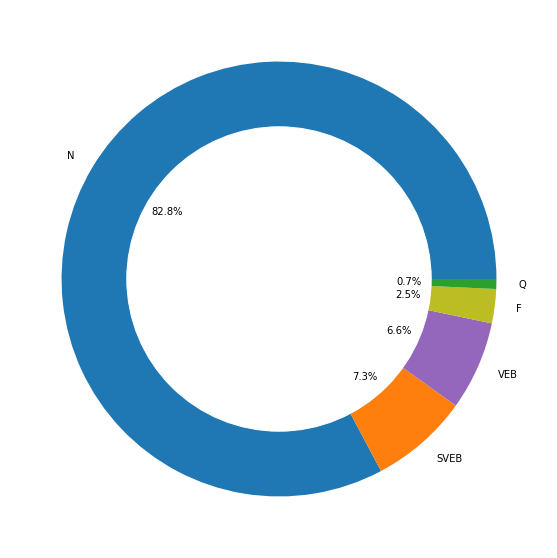

In [12]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'SVEB', 'VEB', 'F', 'Q'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [13]:
X_train_df.shape

(109156, 2001)

In [14]:
X_train_df.shape

(109156, 2001)

In [15]:
print(X_train_df[X_train_df[X_train_df.shape[1]-1]==1])
print(X_train_df[X_train_df[X_train_df.shape[1]-1]==1])
print(X_train_df[X_train_df[X_train_df.shape[1]-1]==2])
print(X_train_df[X_train_df[X_train_df.shape[1]-1]==3])
print(X_train_df[X_train_df[X_train_df.shape[1]-1]==4])

            0         1         2         3         4         5         6     \
3      -0.407356 -0.329716 -0.303836 -0.329716 -0.355596 -0.226196 -0.148556   
226    -0.692036 -0.717916 -0.717916 -0.717916 -0.717916 -0.821436 -0.692036   
254    -0.277956 -0.277956 -0.277956 -0.329716 -0.277956 -0.252076 -0.277956   
338    -0.459116 -0.484996 -0.459116 -0.536756 -0.536756 -0.484996 -0.484996   
437    -0.562636 -0.510876 -0.588516 -0.614396 -0.588516 -0.614396 -0.536756   
...          ...       ...       ...       ...       ...       ...       ...   
107749 -0.205052 -0.219868 -0.234684 -0.308763 -0.279131 -0.279131 -0.249499   
107750 -0.116157 -0.101341 -0.101341 -0.101341 -0.086526 -0.086526 -0.130973   
107751 -0.797684 -0.812500 -0.827316 -0.827316 -0.738421 -0.723605 -0.619894   
107752 -0.649526 -0.664342 -0.664342 -0.708789 -0.753237 -0.768052 -0.738421   
107753 -0.545815 -0.575447 -0.590263 -0.590263 -0.590263 -0.605079 -0.605079   

            7         8         9     .

# Rebalancing Classes

In [ ]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42) # selects random 5000 samples

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122) # upsampling minority classes
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)

X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

4.0    5000
3.0    5000
2.0    5000
1.0    5000
0.0    5000
Name: 2000, dtype: int64


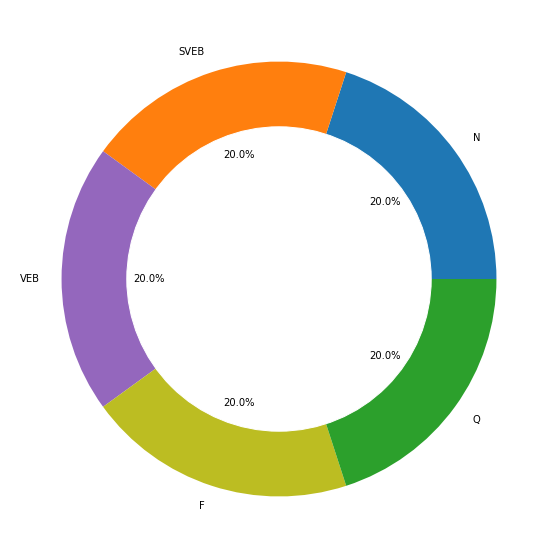

In [17]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'SVEB', 'VEB', 'F', 'Q'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Train-Test Split

In [18]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 2001)
X_test  :  (5000, 2001)


In [ ]:
target_train=train[train.shape[1]-1] # last column (annotation)
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train) # one hot encoding
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [20]:
train

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
102505,-0.052162,-0.143033,0.008418,0.068998,0.159868,0.220448,0.220448,0.250738,0.220448,0.220448,...,0.129578,0.068998,0.008418,0.068998,0.129578,0.129578,0.220448,0.281028,0.462768,1.0
83565,-0.381294,-0.381294,-0.397529,-0.381294,-0.365059,-0.348824,-0.365059,-0.413764,-0.405646,-0.389411,...,0.138228,0.113875,0.065170,0.065170,0.073288,0.121993,0.113875,0.097640,0.105758,4.0
65440,0.651539,0.614241,0.539644,0.483697,0.446399,0.427750,0.371803,0.371803,0.297207,0.129365,...,-0.206318,-0.187669,-0.169020,-0.187669,-0.206318,-0.262265,-0.318212,-0.224967,-0.262265,1.0
50011,0.066792,0.027331,0.040484,0.053638,0.079946,0.066792,0.040484,0.014177,0.014177,0.053638,...,0.053638,0.027331,0.040484,0.106253,0.185175,0.237790,0.277251,0.224636,0.224636,1.0
8693,0.299844,0.040240,-0.339180,-0.638723,-0.778510,-0.538876,-0.259302,-0.019668,0.020271,-0.019668,...,-0.079577,-0.139485,-0.199394,-0.299241,-0.399089,-0.419058,-0.498937,-0.498937,-0.498937,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50902,-0.180854,-0.129274,-0.129274,-0.155064,-0.180854,-0.232434,-0.180854,-0.129274,-0.103484,-0.103484,...,-0.051905,-0.000325,-0.026115,-0.026115,-0.051905,-0.051905,-0.103484,-0.180854,-0.103484,0.0
5978,0.240716,0.188220,0.161971,0.266964,0.345709,0.345709,0.319461,0.293212,0.293212,0.266964,...,0.634439,0.634439,0.634439,0.608191,0.660688,0.739432,0.818177,0.896922,0.975666,4.0
101718,0.190158,0.129578,0.008418,0.008418,0.008418,-0.082452,-0.112743,-0.173323,-0.203613,-0.143033,...,-0.112743,-0.082452,0.068998,0.038708,0.038708,0.008418,-0.052162,0.008418,-0.021872,1.0
99914,-0.380810,-0.409011,-0.352608,-0.352608,-0.282105,-0.225702,-0.197500,-0.155198,-0.169299,-0.155198,...,0.366530,0.281925,0.253724,0.239623,0.225522,0.169119,0.140918,0.084515,-0.000090,0.0


In [ ]:
train_x = train.iloc[:,:train.shape[1]-1].values # leaving out the annotations (last index)
test_x = test.iloc[:,:test.shape[1]-1].values

train_x = train_x.reshape(len(train_x), train_x.shape[1],1) # making each element as a list of single element
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)

print(np.shape(train_x), np.shape(test_x))
print(np.shape(train_y),np.shape(test_y))

(20000, 2000, 1) (5000, 2000, 1)
(20000, 5) (5000, 5)


## Building the Model


In [22]:
model = Sequential()

# Input - (2000 x 1)
model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=train_x[0].shape))
model.add(MaxPool1D(pool_size=3, strides=2))


model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=3, strides=2))


model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=3, strides=2))


model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=3, strides=2))


model.add(Flatten())
model.add(Dropout(0.5))


model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))


model.add(Softmax())


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2000, 16)          224       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 999, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 999, 32)           7712      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 499, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 499, 64)           34880     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 249, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 249, 128)          1

## Compiling the model

In [23]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

## Fitting the model

In [24]:
history = model.fit(train_x, train_y, batch_size=75, epochs=50, verbose=1, validation_data=(test_x, test_y))

Epoch 1/50
267/267 [==============================] - 10s 17ms/step - loss: 0.5228 - accuracy: 0.8175 - val_loss: 0.1688 - val_accuracy: 0.9478
Epoch 2/50
267/267 [==============================] - 4s 13ms/step - loss: 0.1555 - accuracy: 0.9542 - val_loss: 0.1480 - val_accuracy: 0.9594
Epoch 3/50
267/267 [==============================] - 4s 13ms/step - loss: 0.1100 - accuracy: 0.9715 - val_loss: 0.1139 - val_accuracy: 0.9738
Epoch 4/50
267/267 [==============================] - 4s 13ms/step - loss: 0.0911 - accuracy: 0.9789 - val_loss: 0.1046 - val_accuracy: 0.9742
Epoch 5/50
267/267 [==============================] - 4s 13ms/step - loss: 0.0753 - accuracy: 0.9857 - val_loss: 0.0936 - val_accuracy: 0.9798
Epoch 6/50
267/267 [==============================] - 4s 13ms/step - loss: 0.0807 - accuracy: 0.9840 - val_loss: 0.0941 - val_accuracy: 0.9838
Epoch 7/50
267/267 [==============================] - 4s 13ms/step - loss: 0.0730 - accuracy: 0.9866 - val_loss: 0.0915 - val_accuracy: 0.984

**Plotting the loss convergence**

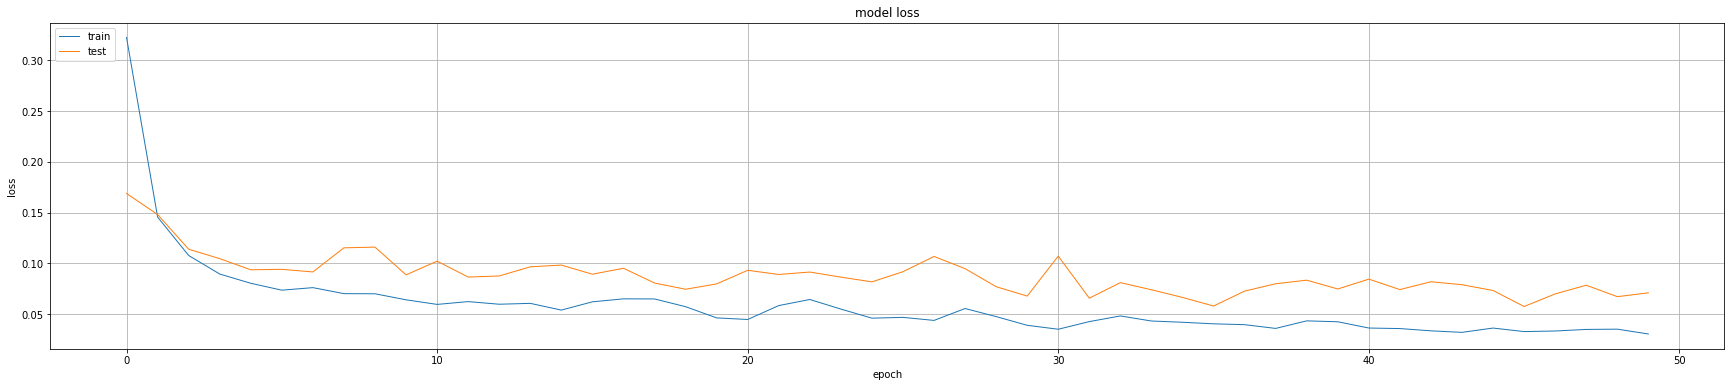

In [25]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Plotting accuracy**

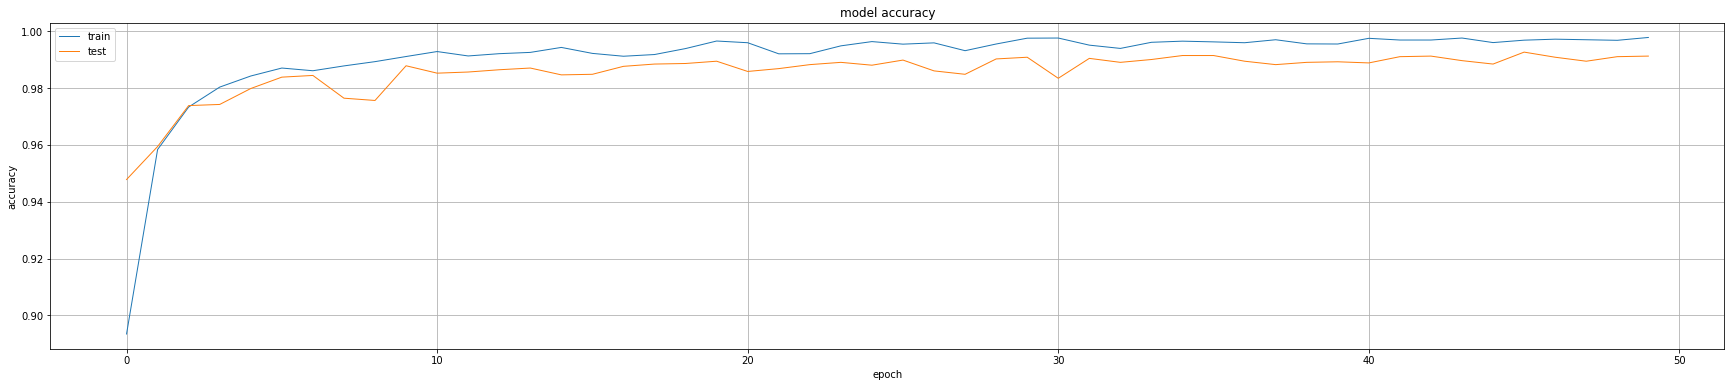

In [26]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
model.save(f'arryhtmia-classification-{window_size}.h5')

## Finding the loss and accuracy of the model

In [28]:
score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

157/157 [==============================] - 1s 3ms/step - loss: 0.0710 - accuracy: 0.9912
Test Loss: 0.07095400989055634
Test accuracy: 0.9911999702453613


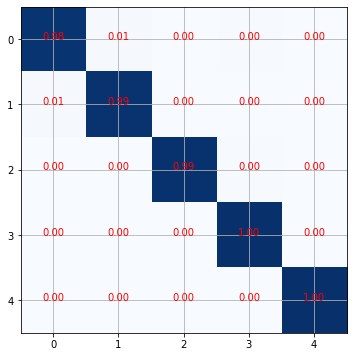

In [29]:
from sklearn.metrics import f1_score, confusion_matrix
pred_y = model.predict(test_x)
cm = confusion_matrix(test_y.argmax(axis=1), pred_y.argmax(axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

for i in range(cm.shape[1]):
    for j in range(cm.shape[0]):
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="red")


plt.imshow(cm, cmap=plt.cm.Blues)

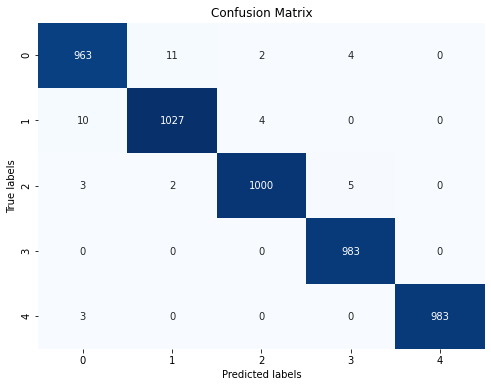

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict and calculate the confusion matrix without normalization
pred_y = model.predict(test_x)
cm = confusion_matrix(test_y.argmax(axis=1), pred_y.argmax(axis=1))

# Create a heatmap with integer annotations
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# Set labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

In [33]:
# Test data class labels spread

print("The distribution of test set labels")
print(test[X_train_df.shape[1]-1].value_counts())

print('F1_score = ', f1_score(test_y.argmax(axis=1), pred_y.argmax(axis=1), average = 'macro'))


The distribution of test set labels
1.0    1041
2.0    1010
4.0     986
3.0     983
0.0     980
Name: 2000, dtype: int64
F1_score =  0.99123261065291


Actual label:  F
Model prediction :  F  with probability  1.0


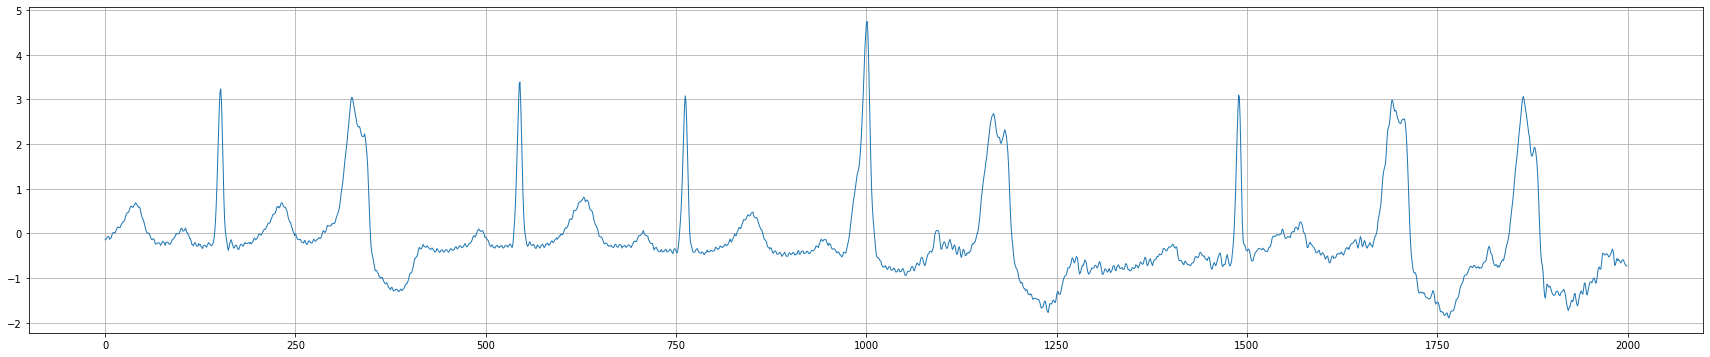

In [34]:
import random
i = random.randint(0, len(test_x)-1)

output = model(np.expand_dims(test_x[i], 0))

pred = output.numpy()[0]

plt.plot(test_x[i])

print("Actual label: ", classes[np.argmax(test_y[i])])
print("Model prediction : ", classes[np.argmax(pred)], " with probability ", pred[np.argmax(pred)])

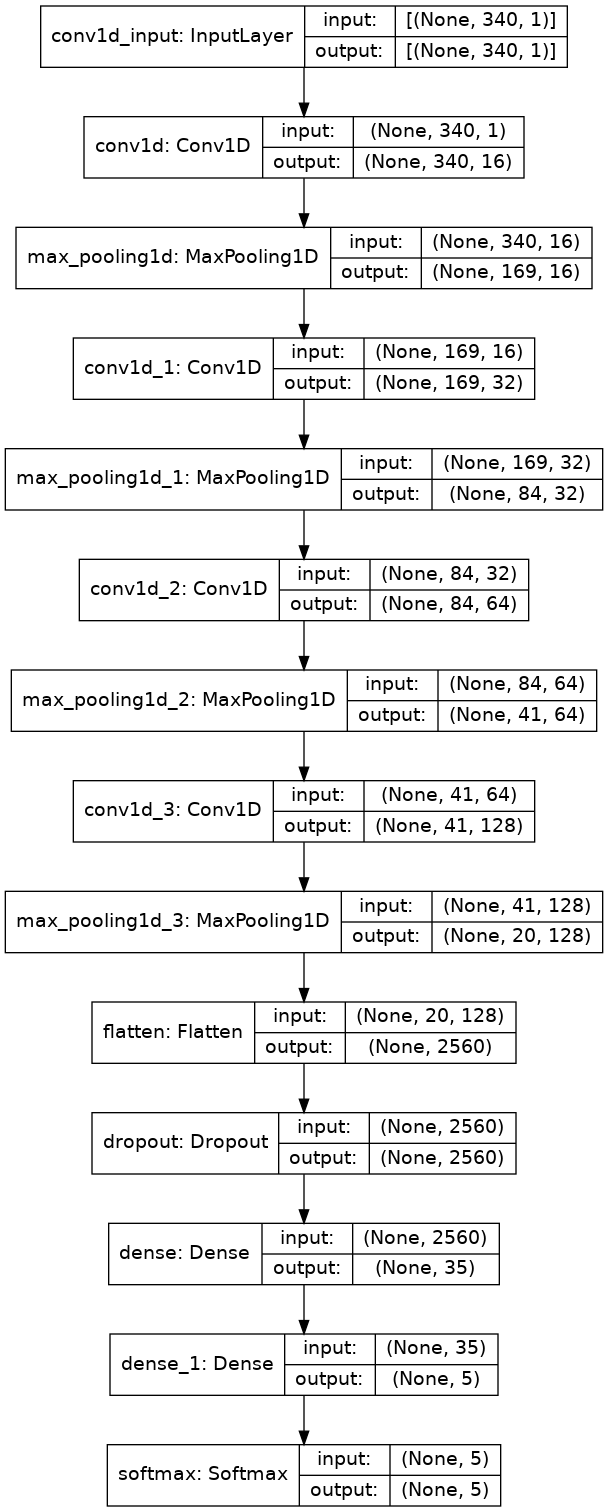

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Predict the labels on the test data
pred_y = model.predict(test_x)
pred_classes = pred_y.argmax(axis=1)
true_classes = test_y.argmax(axis=1)

# Classification report
report = classification_report(true_classes, pred_classes, target_names=classes)
print("Classification Report:\n", report)

# Calculate total samples, correct predictions, and overall accuracy
total_samples = len(test_y)
correct_predictions = (pred_classes == true_classes).sum()
overall_accuracy = accuracy_score(true_classes, pred_classes)

print(f"Total samples: {total_samples}")
print(f"Correct predictions: {correct_predictions}")
print(f"Overall accuracy: {overall_accuracy:.2f}")


Classification Report:
               precision    recall  f1-score   support

           N       1.00      0.98      0.99       971
        SVEB       0.99      0.99      0.99       986
         VEB       0.99      0.99      0.99       985
           F       0.98      1.00      0.99      1006
           Q       1.00      1.00      1.00      1052

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000

Total samples: 5000
Correct predictions: 4955
Overall accuracy: 0.99
